# An Introduction to Supervised Classification

### Notebook created by [Bright Cape](https://brightcape.nl/)
*Author: Maurits Akkerman*

## Table of contents

* [Introduction](#Introduction)

* [Step 1: Data Preprocessing](#Step-1:-Data-Preprocessing)

    - [Under and Overfitting](#1.1:-Under-and-Overfitting)

* [Step 2: Model Creation and Parameter Tuning](#Step-2:-Model-Creation-and-Parameter-Tuning)

    - [Decision Tree](#2.1:-Decision-Tree)
    
        * [Classifier](#2.1.1:-Decision-Tree-Classifier)
    
        * [Regressor](#2.1.2:-Decision-Tree-Regressor)

    - [Random Forests](#2.2:-Random-Forests)

    - [K-Nearest Neighbor](#2.3:-K-Nearest-Neighbor)

* [Step 3: Model Validation](#Step-3:-Model-Validation)
* [Conclusion](#Conclusion) 


# Introduction

[[ go back to the top ]](#Table-of-contents)

In the previous notebooks, we showed the time and effort required to properly clean datasets. Additionally, we showed how to set up a linear regression model. This notebook will focus on the subsequent modelling steps and show how to set up a supervised machine learning model.

<img src="https://drive.google.com/uc?id=1yX1hvNeepHnm1O58voKm_qQultGcpNOy" style="width: 800px;" />


Machine Learning Algorithms (MLA) can be categorized into two classes: supervised and unsupervised learning. In supervised learning, we know what the outcome of our model should be. We provide our model with examples and provide the results of these examples. Then, we provide our model with new examples and ask the model to predict the outcomes. In unsupervised learning, we do not know what the outcome of our model should be. These models are used for discovering similarities, structures, and associations.

In our case, we want to learn more about the transaction behavior of google analytics customers. Therefore, the outcome of the model is known. Namely, we want to predict whether a transaction takes place, and if so what the size of that transaction would be.

This notebook is set up in the following manner: First, we will include some steps required to use our cleaned data in MLA, we will discuss two commonly used method Decision Trees with the extension to Random Forests, and K-Nearest Neighbour. Finally, the performance of each model is compared and the best is chosen.

### Import Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# this allows plots to appear directly in the notebook
%matplotlib inline

### Import Cleaned Dataset

In [2]:
import requests
from io import StringIO

orig_url='https://drive.google.com/file/d/1SJWwLTX6lHKP13A-PudfRnuN7s-_5vxy/view?usp=sharing'
dwn_url='https://drive.google.com/uc?export=download&id=' + orig_url.split('/')[-2]
url = requests.get(dwn_url).text
csv_raw = StringIO(url)

# Read the data into a pandas data frame and show the first 5 rows
data = pd.read_csv(csv_raw, index_col=0, sep=',')
data['date'] = pd.to_datetime(data['date'],  format='%Y-%m-%d', errors='coerce')
data.head()

,visitNumber,date,hits,pageviews,timeOnSite,totalTransactionRevenue,campaign,medium,browser,operatingSystem,isMobile,continent
0,1,2016-08-05,11,11,225.0,52.00,(not set),organic,Chrome,Chrome OS,0,Americas
1,1,2016-08-05,60,39,1848.0,83.99,(not set),(not set),Chrome,Linux,0,Americas
2,5,2016-08-05,40,29,2180.0,30.18,(not set),(not set),Chrome,Macintosh,0,Americas
3,1,2016-08-05,63,51,2407.0,29.19,(not set),(not set),Chrome,Macintosh,0,Americas
5,11,2016-08-05,47,34,1472.0,70.36,(not set),(not set),Chrome,Macintosh,0,Americas


# Step 1: Data Preprocessing
[[ go back to the top ]](#Table-of-contents)

Simply dumping all available data in a machine learning model is often not possible. First, several data transformation steps should be performed. For example, most machine learning algorithms can't deal with categorical variables such as "medium". To retain the information we need to transform it into multiple features. For each possible category of the original variable, a new binary feature is defined. See the example below:

In [3]:
subset = data['medium'].copy()
subset = pd.get_dummies(data = subset)
subset.head()

,(not set),affiliate,cpc,cpm,organic,referral
0,0,0,0,0,1,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
5,1,0,0,0,0,0


Besides these transformations, to achieve our goal of whether a transaction occurred yes or no, we add a variable called "transaction" that provides us with just this information.

In [4]:
# Create a copy of the original dataset
subset = data.copy()

# Add a binary variable called transaction that indicates wheter a transaction occured.
# For example a totalTransaction value of 100 indicates a transaction took place and hence the variable transaction is set to 1.
subset['transaction'] = np.where(subset['totalTransactionRevenue'] > 0, 1, 0).tolist()

# Add a month and year variable to prevent overfitting on dates. More on over and underfitting in the next subsection.
subset['month'] = subset['date'].dt.month
subset['year'] = subset['date'].dt.year

To get an intuitive understanding of the factors influencing whether a transaction occured, we make some visualizations.

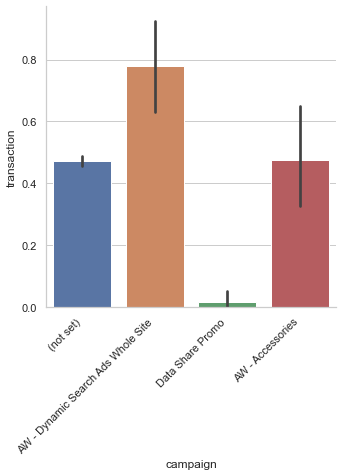

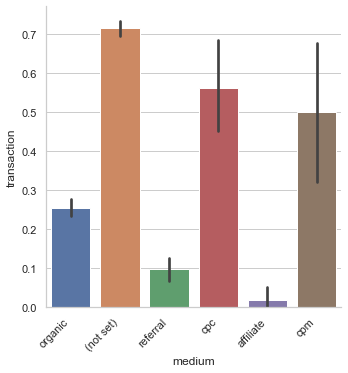

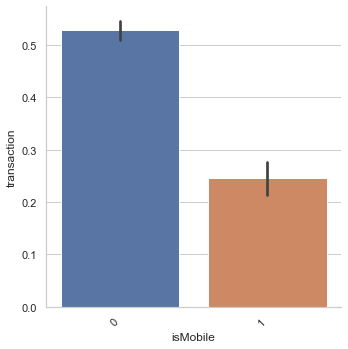

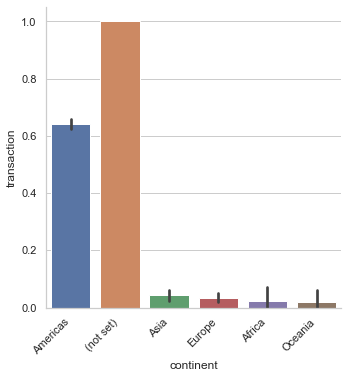

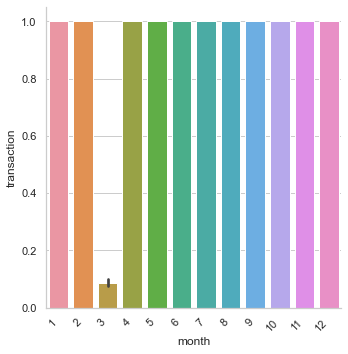

In [6]:
# Visualize variables and their effect on whether a transaction occured
sns.set(style="whitegrid")
ax = sns.catplot(x="campaign", y="transaction", data=subset,kind="bar")
ax.set_ylabels("transaction")
ax.set_xticklabels(ha='right', rotation=45)

ax = sns.catplot(x="medium", y="transaction", data=subset,kind="bar")
ax.set_ylabels("transaction")
ax.set_xticklabels(ha='right', rotation=45)

ax = sns.catplot(x="isMobile", y="transaction", data=subset,kind="bar")
ax.set_ylabels("transaction")
ax.set_xticklabels(ha='right', rotation=45)

ax = sns.catplot(x="continent", y="transaction", data=subset,kind="bar")
ax.set_ylabels("transaction")
ax.set_xticklabels(ha='right', rotation=45)

ax = sns.catplot(x="month", y="transaction", data=subset,kind="bar")
ax.set_ylabels("transaction")
ax.set_xticklabels(ha='right', rotation=45)

From these plots, we can observe that most variables have a clear effect on a transaction occurring. However, when taking a closer look at the month variable, only in March not all observations were transactions. If we dive deeper into this observation, we find that march has over 50% of the total records. Thus it appears that in the data collection only the non-transactions in March were collected and not for any other months.

This observation requires us, data scientist, to question the data provider. Is there an explanation for this observation? Is data missing?

It turns out that the provided dataset is balanced, having equal transactions and non-transactions. The consequence of only having non-transaction observations in March is that we can not use the date variable as a prediction, as it would be unrealistic to assume no non-transaction occurred during the other months.

In [7]:
# Let's drop the date variables as clearly there the non-transaction were only recorded during the month March
subset.drop(['date', 'month', 'year'], axis=1, inplace=True)

# Since using a single data likely overfits the model
subset = pd.get_dummies(data = subset)

# Show an example of the top rows of the dataset
subset.head()

,visitNumber,hits,pageviews,timeOnSite,totalTransactionRevenue,isMobile,transaction,campaign_(not set),campaign_AW - Accessories,campaign_AW - Dynamic Search Ads Whole Site,...,operatingSystem_Samsung,operatingSystem_Windows,operatingSystem_Windows Phone,operatingSystem_iOS,continent_(not set),continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania
0,1,11,11,225.0,52.00,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,60,39,1848.0,83.99,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,5,40,29,2180.0,30.18,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,63,51,2407.0,29.19,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
5,11,47,34,1472.0,70.36,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0


## 1.1: Under and Overfitting
[[ go back to the top ]](#Table-of-contents)

Providing a MLA with all available data is a common mistake in data science projects. After all, more data is better, right? Unfortunately, no. A model can be trained to 100% accurately predict the outcome based on a dataset. However, when we then use new observations slightly different from the original dataset, wrong predictions can occur. The figure below provides a good example of under and overfitting:

<img src="https://drive.google.com/uc?id=1gVlMa3l2Rm8ulUoCVErA_ov8zpyzKsnK" style="width: 600px;" />

Now, what do we do to prevent overfitting? First, we split the total data into two: a training data set and a testing data set. The percentage of the data that should be used for the training and testing set is usually set at 75% training and 25% testing. This split can be altered to include more or less training data. In the end, there is always a tradeoff between using as much training data to create the best set up of the model, while still having enough data to get a representative testing sample to unbiasedly judge it's performance.

In [26]:
# We're using all our variables EXCEPT for the totalTransactionRevenue and transaction to predict our variables

# Note that scikit-learn expects each entry to be a list of values, e.g.,
# [ [val1, val2, val3],
#   [val1, val2, val3],
#   ... ]
# such that our input data set is represented as a list of lists

# We can extract the data in this format from pandas like this:
all_inputs = subset.drop(columns=['totalTransactionRevenue', 'transaction']).values

# Similarly, we can extract the class labels
all_labels = subset['transaction'].values

# Import the function to divide the dataset in training and testing sets
from sklearn.model_selection import train_test_split

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25, random_state=1)

A more robust version of splitting the data into test and training sets is to use cross-validation. This methodology iteratively trains and tests the model on different subsets of the data. The actual model performance is then determined based on the average performance over all these cross-validations. An example of cross-validation with size 5 is provided in the image below: 

<img src="https://drive.google.com/uc?id=1LVI3FpUSCYPFYNohGPDZQa9Binh3Mjgm" style="width: 500px;"/>

The topic of cross-validation is revisited in the next chapter. Here, we discuss and show the differences in accuracy between the "normal" approach and cross-validation.

# Step-2:-Model-Creation-and-Parameter-Tuning
[[ go back to the top ]](#Table-of-contents)

## 2.1: Decision Tree
We'll start with a model called the Decision Tree. Some fancier models give more accurate predictions, but decision trees are easy to understand. Further, they are at the foundation of some of the best models in data science.
 
A decision tree consists of nodes and leaves connected by branches. A node is a decision point. For example, we decide which branch to follow based on whether the number of hits is larger than 40. A leaf is an endpoint of the tree and makes the prediction. The prediction of one observation is therefore determined by its variables and is set by the leaf it ends on.

In this notebook, we consider two types of trees, classifiers and regressors. A classifier classifies an observation as either "yes" or "no". For the google analytics data this would mean: "did a sale take place?" to which the decision tree classifier predicts either "yes" or "no". A regressor estimates the value of an observation. For the same example, the output question would be: "how much was the total transaction revenue" to which the decision tree regressor will predict for example 450 (or any other number, including 0).

Now let's take a look at both a classifier example as well as a regressor.

### 2.1.1: Decision Tree Classifier

We have already defined the classifier labels above and thus we can instantly fit our model to the data.

In [27]:
from sklearn.tree import DecisionTreeClassifier

# Create the classifier
decision_tree_classifier = DecisionTreeClassifier(random_state=1)

# Train the classifier on the training set
decision_tree_classifier.fit(training_inputs, training_classes)

# Check how accurate the classifier predicts whether a transaction took place
print('Accuracy of the Decision Tree Classifier {:.2%}'.format(decision_tree_classifier.score(testing_inputs, testing_classes)))

Accuracy of the Decision Tree Classifier 93.75%


So with 93.75% accuracy, we predicted whether a transaction took place or not based on the input parameters. We can further investigate how this tree is created and of which nodes and leaves it exists. 

The depth of a tree is the number of decision points between the input and output of the decision tree. The depth of this tree has not been specified. Since it would be extremely confusing to show the entire tree, we stop further branching when reaching a depth of three nodes.

In [10]:
from sklearn.tree import export_text
text_representation = export_text(decision_tree_classifier, feature_names = subset.columns.drop(['transaction', 'totalTransactionRevenue']).tolist(), max_depth = 3, spacing = 8)
print(text_representation)

|-------- pageviews <= 8.50
|        |-------- pageviews <= 4.50
|        |        |-------- operatingSystem_Linux <= 0.50
|        |        |        |-------- class: 0
|        |        |-------- operatingSystem_Linux >  0.50
|        |        |        |-------- timeOnSite <= 107.00
|        |        |        |        |-------- class: 0
|        |        |        |-------- timeOnSite >  107.00
|        |        |        |        |-------- truncated branch of depth 2
|        |-------- pageviews >  4.50
|        |        |-------- visitNumber <= 1.50
|        |        |        |-------- pageviews <= 6.50
|        |        |        |        |-------- class: 0
|        |        |        |-------- pageviews >  6.50
|        |        |        |        |-------- truncated branch of depth 5
|        |        |-------- visitNumber >  1.50
|        |        |        |-------- timeOnSite <= 149.00
|        |        |        |        |-------- truncated branch of depth 4
|        |        |     

Now let's figure out how we should read this tree. Consider an observation that has 8 pageviews. The first node is: "pageviews <= 8.5", and consequently a little further down: "pageviews > 8.5". As our example had 8 pageviews we follow the first branch and move to the second node. The question now is "pageviews <= 4.5". In our case it is not and therefore, we follow the second branch. And so on, until a leaf is reached. We observe several leaves in the first branch. These leaves state "class: 0" or "class: 1" and thus, provides the outcome of the tree.

The created decision tree is based on the training dataset and its accuracy is determined by the testing dataset. What would happen if we change these training and testing sets?

''

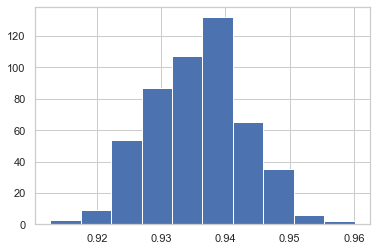

In [28]:
model_accuracies = []

for repetition in range(500):
    # Make new testing and training datasets
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)
    
    # Run the decision tree classifier again and determine it's score
    decision_tree_classifier = DecisionTreeClassifier(random_state=1)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
    
plt.hist(model_accuracies, bins = 10)
;

As we can see, the results of the decision tree are all over the place. They are extremely dependent on which training- and testingset you provide. This is an example of overfitting. As explained earlier we can balance the amount of overfitting by using cross-validation methods.

In [34]:
from sklearn.model_selection import cross_val_score

# cross_val_score returns a list of the scores, taking the average provides a good estimate of the model performance.
# This method is a lot less sensitive to what training or testing sets are provided to the model and therefore provides
# a better measure of the true model performance.
cv_scores = cross_val_score(DecisionTreeClassifier(random_state=1), all_inputs, all_labels, cv=10)
print('Average accuracy of the Decision Tree classifier: {:.2%}'.format(np.mean(cv_scores)))

Average accuracy of the Decision Tree classifier: 93.53%


Now we have an average accuracy of 93.53% based on 10 different splits of the training and testing data. This score is much more robust than the previous method. If we perform the same iteration of 100 different scores, we can see that the range of the decision tree scores is much tighter relative to the image above!

''

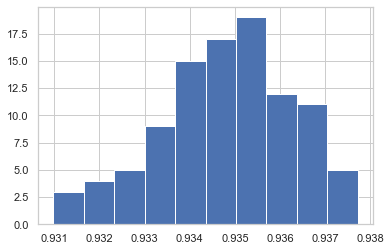

In [13]:
model_accuracies = []

for repetition in range(100):
    # Run the decision tree classifier again but now with cross validation and determine the average score
    cv_scores = cross_val_score(DecisionTreeClassifier(), all_inputs, all_labels, cv=10)
    model_accuracies.append(np.mean(cv_scores))

plt.hist(model_accuracies, bins = 10)
;

### Parameter tuning

Before, we mentioned the parameter depth of a tree. This parameters can be optimized to increase the performance of the model. Another parameter is the maximum number of variables to consider. There are many more variables to change and tweak, but for now, let's focus on these two. Subsequently, we can look at each combination of depth and variables and visualize the performance of the tree in a grid. This approach is called a grid search.

Accuracy of the best Decision Tree Classifier: 95.36%
Best Performance found with a max depth: 5 and max features: 9


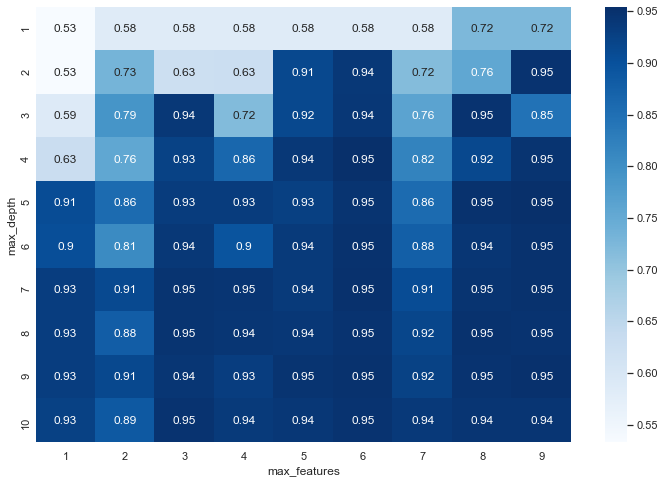

In [14]:
from sklearn.model_selection import GridSearchCV

# Specify the parameters we want to tune, in this case the depth and number of variables.
number_depth = 10
number_features = 9
parameter_grid = {'max_depth': [i+1 for i in range(number_depth)],
                  'max_features': [i+1 for i in range(number_features)]}

# Initalize the grid search
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1),
                           param_grid=parameter_grid,
                           cv=10)
# Fit the grid search based on the inputs and classes.
grid_search.fit(all_inputs, all_labels)

# Visualize the performance of sets of input parameters
fig, ax = plt.subplots(figsize = (12,8))
grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (number_depth, number_features)
sns.heatmap(grid_visualization, cmap='Blues', annot=True)
ax.set_xticklabels(grid_search.param_grid['max_features'], ha = 'center')
ax.set_yticklabels(grid_search.param_grid['max_depth'], ha = 'center')
ax.set_xlabel('max_features')
ax.set_ylabel('max_depth')

# Return the best classifier
decision_tree_classifier = grid_search.best_estimator_
print('Accuracy of the best Decision Tree Classifier: {:.2%}'.format(grid_search.best_score_),
     'Best Performance found with a max depth: {} and max features: {}'.format(decision_tree_classifier.max_depth, decision_tree_classifier.max_features),
     sep='\n')

The best Classification Tree we can create is a tree with a max depth of 5 nodes and a max number of features of 9. By using these features, we increase our performance from 93.75% to over 95.36%!

### 2.1.2: Decision Tree Regressor
[[ go back to the top ]](#Table-of-contents)

Compared to the Decision Tree Classifier we now have to change our output. The output for the classifier was a binary variable indicating whether a transaction occurred, whereas now we are trying to predict what the expected revenue of a transaction is.

In [15]:
# The inputs stay the same, but we change the label from transaction to totalTransactionRevenue
all_labels = subset['totalTransactionRevenue'].values

# Import the Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

# Create the regressor
decision_tree_regressor = DecisionTreeRegressor(random_state=1)

# Check the score of the created model through the k-fold cross validation method
cv_scores = cross_val_score(decision_tree_regressor, all_inputs, all_labels, cv=10)
print('Average accuracy score: {:.2%}'.format(np.mean(cv_scores)))

Average accuracy score: -101.34%


WOW what happened there, suddenly the prediction is way off. Keep in mind that a score of 0.0 normally indicates that we make a prediction without looking at the inputs. Let's look at what type of predictions we would make with this model:

In [16]:
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25, random_state=1)
decision_tree_regressor.fit(training_inputs, training_classes)
prediction = decision_tree_regressor.predict(testing_inputs)

for i in range(15):
    print('{}: Predicted: {:.1f} Actual: {:.1f}'.format(i,prediction[i],testing_classes[i]))

0: Predicted: 0.0 Actual: 0.0
1: Predicted: 21.6 Actual: 16.0
2: Predicted: 15.0 Actual: 52.3
3: Predicted: 38.0 Actual: 54.8
4: Predicted: 26.0 Actual: 36.4
5: Predicted: 0.0 Actual: 0.0
6: Predicted: 35.6 Actual: 176.8
7: Predicted: 0.0 Actual: 33.2
8: Predicted: 0.0 Actual: 0.0
9: Predicted: 0.0 Actual: 0.0
10: Predicted: 47.7 Actual: 24.5
11: Predicted: 108.7 Actual: 25.8
12: Predicted: 0.0 Actual: 21.0
13: Predicted: 111.9 Actual: 21.0
14: Predicted: 20.0 Actual: 31.0


Let's see if this problem is caused by the input. When predicting the exact value of the total transaction revenue the effect of extreme values could be an issue. To explain why let's consider the following example. A leaf has 40 samples with a transaction revenue between 0 and 50, let's say 25 on average, and 1 observation with a revenue of 1000. The predicted revenue for that leaf is determined by the average of all observations. In this case, the average would be 48 $(=\frac{25 \cdot 40 + 1 \cdot 1000}{41})$. The estimation of 48 now overestimates the revenue for the majority of observations and extremely underestimates it for the extreme value. 

Looking at the predictions made above, we can see that for observation the predicted value is 111.9, while the actual value is 21. This could potentially be caused by just such an example.

Maybe we can increase the score of our model by looking at the majority of the observations. So let's remove the 10% highest revenue observations.

Additionally, let's only look at the rows where a transaction occurred.

In [35]:
# Remove all rows where no transaction occured
subset2 = subset[subset['transaction'] != 0]

# Respecify the inputs and labels for the MLA
all_inputs2 = subset2.drop(columns=['transaction', 'totalTransactionRevenue']).values
all_labels2 = subset2['totalTransactionRevenue'].values

# Create the regressor
decision_tree_regressor = DecisionTreeRegressor(random_state=1)

# Check the score of the created model through the k-fold cross validation method
cv_scores = cross_val_score(decision_tree_regressor, all_inputs2, all_labels2, cv=10)
print('Average accuracy score: {:.2%}'.format(np.mean(cv_scores)))


Average accuracy score: -81.84%


Clearly that didn't solve our problem. One last option would be to look at the parameters, but due to the low score, it is highly unlikely that the revenue can be predicted based on our current input parameters.

Accuracy of the best Decision Tree Regressor: 2.92%
Best Performance found with a max depth: 4 and max features: 5


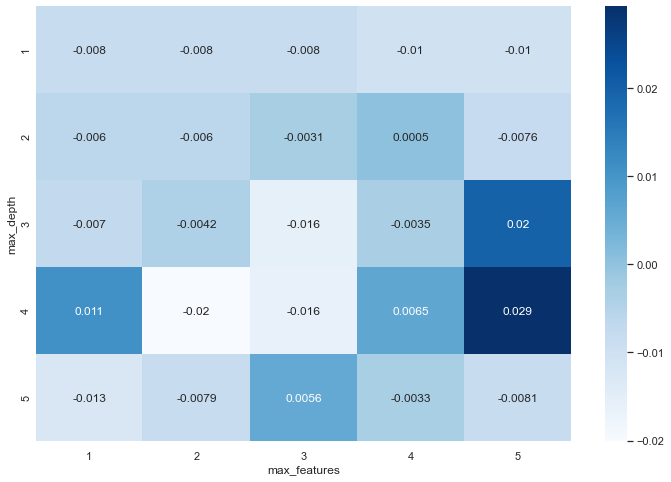

In [36]:
# Specify the parameters we want to tune, in this case the depth and number of variables.
number_depth = 5
number_features = 5
parameter_grid = {'max_depth': [i+1 for i in range(number_depth)],
                  'max_features': [i+1 for i in range(number_features)]}

# Initalize the grid search
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=1),
                           param_grid=parameter_grid,
                           cv=10)

# Fit the grid search based on the inputs and classes.
grid_search.fit(all_inputs2, all_labels2)

# Visualize the performance of sets of input parameters
fig, ax = plt.subplots(figsize = (12,8))
grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (number_depth, number_features)
sns.heatmap(grid_visualization, cmap='Blues', annot=True)
ax.set_xticklabels(grid_search.param_grid['max_features'], ha='center')
ax.set_yticklabels(grid_search.param_grid['max_depth'], ha='center')
ax.set_xlabel('max_features')
ax.set_ylabel('max_depth')

# Return the best classifier
decision_tree_regressor = grid_search.best_estimator_
print('Accuracy of the best Decision Tree Regressor: {:.2%}'.format(grid_search.best_score_),
     'Best Performance found with a max depth: {} and max features: {}'.format(decision_tree_regressor.max_depth, decision_tree_regressor.max_features),
     sep='\n')

As predicted, the score does not get much better. From these analyses, we can conclude that current input parameters do not provide enough information to predict the height of the revenue. The remainder of this notebook, therefore, focusses on classifying a transaction.

## 2.2: Random Forests
[[ go back to the top ]](#Table-of-contents)

In the previous models, we looked at a single decision tree. But what if we combined the power of multiple trees to make our prediction? That is exactly what a random forest is. It trains multiple different trees and bases its output on the average outcome of those trees.

When using classifiers, the class that is predicted is based on the majority class of the individual tree predictions. While for Regressors a simple average of all predictions is used.

Since we concluded that determining the exact value of a transaction is not viable. We only focus on predicting whether a transaction is going to occur.

The following blocks of code perform the same steps as before, looking at the initial accuracy of the random forest and applying a grid search to optimize the optimal parameters

In [19]:
# Change the output variable back to transaction
all_labels = subset['transaction'].values

from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier(n_estimators = 10, random_state = 1)

# Check the score of the created model through the k-fold cross validation method
cv_scores = cross_val_score(random_forest_classifier, all_inputs, all_labels, cv=10)
print('Average accuracy of the Random Forest Classifier: {:.2%}'.format(np.mean(cv_scores)))

Average accuracy of the Random Forest Classifier: 95.58%


In [20]:
# Parameter tuning
parameter_grid = {'n_estimators': [10, 25, 50, 100],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [2, 4, 6, 8]}

# Initalize the grid search
grid_search = GridSearchCV(RandomForestClassifier(random_state = 1),
                           param_grid=parameter_grid,
                           cv=10)

# Fit the grid search based on the inputs and classes.
grid_search.fit(all_inputs, all_labels)

# Return the best classifier
random_forest_classifier = grid_search.best_estimator_
print('Accuracy of the best Random Forest model: {:.2%}'.format(grid_search.best_score_),
     'Best Performance found with {} estimators and {} features'.format(random_forest_classifier.n_estimators, random_forest_classifier.max_features),
     sep='\n')

Accuracy of the best Random Forest model: 95.79%
Best Performance found with 50 estimators and 8 features


Compared to a single tree with 95.36% accuracy we have now improved to 95.79% accuracy. While this example is not an extreme increase. Generally speaking, Random forests are much more powerful compared to Decision Trees.

## 2.3: K-Nearest Neighbor
[[ go back to the top ]](#Table-of-contents)

The K-nearest neighbor algorithm is less intuitive than the decision tree. It predicts the value of an observation based on it's closest K neighbors. An example is given in the picture below:

<img src="https://drive.google.com/uc?id=17t6BFgqurWas3QNihxNPHt7u7qGFkHdY" style="width: 300px;"/>

Let's perform the same steps as for the previous models and optimize our model parameters through a grid search.


In [21]:
from sklearn.neighbors import KNeighborsClassifier

# Set K neighbor equal to 3
knn = KNeighborsClassifier(n_neighbors=3)

# Check the score of the created model through the k-fold cross validation method
cv_scores = cross_val_score(knn, all_inputs, all_labels, cv=10)
print('Average accuracy of a KNN model with {} neighbors: {:.2%}'.format(knn.n_neighbors, np.mean(cv_scores)))

Average accuracy of a KNN model with 3 neighbors: 92.26%


Accuracy of the best KNN model: 92.26%
Best Performance found with 3 neighbors


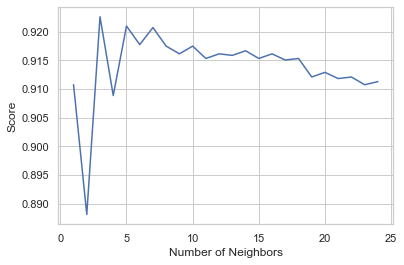

In [22]:
# Parameter tuning
parameter_grid = {'n_neighbors': [i for i in range(1,25)]}

# Initalize the grid search
grid_search = GridSearchCV(KNeighborsClassifier(),
                           param_grid=parameter_grid,
                           cv=10)

# Fit the grid search based on the inputs and classes.
grid_search.fit(all_inputs, all_labels)

# Visualize performance of number of neighbors
plt.plot(range(1,25),grid_search.cv_results_['mean_test_score'])
plt.xlabel("Number of Neighbors")
plt.ylabel("Score")

# Return the best classifier
knn = grid_search.best_estimator_
print('Accuracy of the best KNN model: {:.2%}'.format(grid_search.best_score_),
     'Best Performance found with {} neighbors'.format(knn.n_neighbors),
     sep='\n')


The best performing model uses 3 neighbors to make a prediction. Interestingly, this results in a worse accuracy compared to the decision trees and random forests.

## Step 3: Model Validation
[[ go back to the top ]](#Table-of-contents)

In Machine Learning, there is no such thing as one "best" model. Rather we try to apply multiple different models and see which ones outperform others. In this case, let's compare the three models we have created so far:

''

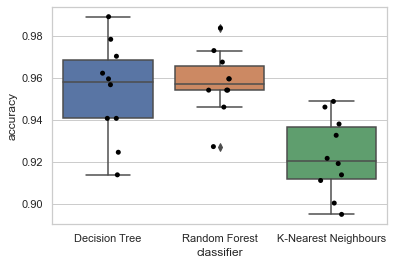

In [23]:
dt_df = pd.DataFrame({'accuracy': cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=10),
                      'classifier': ['Decision Tree'] * 10})
rf_df = pd.DataFrame({'accuracy': cross_val_score(random_forest_classifier, all_inputs, all_labels, cv=10),
                       'classifier': ['Random Forest'] * 10})
knn_df = pd.DataFrame({'accuracy': cross_val_score(knn, all_inputs, all_labels, cv=10),
                      'classifier': ['K-Nearest Neighbours'] * 10})
two_df = dt_df.append(rf_df)
all_df = two_df.append(knn_df)

sns.boxplot(x='classifier', y='accuracy', data=all_df)
sns.stripplot(x='classifier', y='accuracy', data=all_df, jitter=True, color='black')
;

As observed earlier, the Decision Tree and Random Forest Classifier perform almost equal and the K-nearest neighbor algorithm performs slightly worse.

Besides looking at just one indicator of accuracy, we can further divide our predictions into four categories: true positives, true negatives, false positives, and false negatives.

Depending on the business question at hand, some categories might carry more weight than others. For example, if we are trying to predict product failure of a vital component in an airplane, a false negative is extremely dangerous, whereas a false positive is less important.

To distinguish these criteria, three metrics are defined.
- Precision: Answers the question of how many selected items are relevant? How many of the classes that we predicted as positive are actually positive?
- Recall: Answers the question of how many relevant items are selected? How many of the total positive cases are identified as positive
- F1: A measure that combines the metrics precision and recall, providing a decision based on a single metric.



In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)
    
predictions = decision_tree_classifier.predict(testing_inputs)

matrix = confusion_matrix(testing_classes, predictions)
print("Decision Tree Results:",
    "True Positives: {}".format(matrix[0][0]),
     "False Positives: {}".format(matrix[1][0]), 
     "True Negatives: {}".format(matrix[0][1]),
     "False Negatives: {}".format(matrix[1][1]),
      classification_report(testing_classes, predictions),
      sep='\n')

print()

predictions = random_forest_classifier.predict(testing_inputs)
matrix = confusion_matrix(testing_classes, predictions)
print("Random Forest Results:",
    "True Positives: {}".format(matrix[0][0]),
     "False Positives: {}".format(matrix[1][0]), 
     "True Negatives: {}".format(matrix[0][1]),
     "False Negatives: {}".format(matrix[1][1]),
      classification_report(testing_classes, predictions),
      sep='\n')


Decision Tree Results:
True Positives: 469
False Positives: 13
True Negatives: 29
False Negatives: 417
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       498
           1       0.93      0.97      0.95       430

    accuracy                           0.95       928
   macro avg       0.95      0.96      0.95       928
weighted avg       0.96      0.95      0.95       928


Random Forest Results:
True Positives: 498
False Positives: 0
True Negatives: 0
False Negatives: 430
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       498
           1       1.00      1.00      1.00       430

    accuracy                           1.00       928
   macro avg       1.00      1.00      1.00       928
weighted avg       1.00      1.00      1.00       928



We can see that in the sample we used, we perfectly predicted the classes by using the random forest classifier!

Though in reality, when we want to compare different MLA, we would need another testing set. This set should be seperates at the first stage of the analysis as during the optimization of parameters we actually used the current testing set. So in essence we are again overfitting!

## Conclusion
[[ go back to the top ]](#Table-of-contents)

This notebook serves as an example of how machine learning is used in practice. It also shows that not all machine learning algorithms necessarily deliver a valuable outcome in business contexts. We always have to keep in mind, what do we want to achieve with our model? and sometimes the answer is simply: we do not have enough or the right data.

Remember one of the main mottos of data science: __"Better Data Beast Fancier Algorithms"__